In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rania121","key":"214a81c41cafd2a04cf2b029606405a5"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d sovitrath/road-lane-segmentation-train-test-split

Dataset URL: https://www.kaggle.com/datasets/sovitrath/road-lane-segmentation-train-test-split
License(s): ODbL-1.0
 77% 128M/167M [00:00<00:00, 1.34GB/s]
100% 167M/167M [00:00<00:00, 1.22GB/s]


In [4]:
!unzip road-lane-segmentation-train-test-split.zip

Archive:  road-lane-segmentation-train-test-split.zip
  inflating: train/images/0060_Image1.jpg  
  inflating: train/images/0060_Image10.jpg  
  inflating: train/images/0060_Image11.jpg  
  inflating: train/images/0060_Image13.jpg  
  inflating: train/images/0060_Image14.jpg  
  inflating: train/images/0060_Image15.jpg  
  inflating: train/images/0060_Image16.jpg  
  inflating: train/images/0060_Image17.jpg  
  inflating: train/images/0060_Image18.jpg  
  inflating: train/images/0060_Image19.jpg  
  inflating: train/images/0060_Image2.jpg  
  inflating: train/images/0060_Image22.jpg  
  inflating: train/images/0060_Image25.jpg  
  inflating: train/images/0060_Image26.jpg  
  inflating: train/images/0060_Image27.jpg  
  inflating: train/images/0060_Image28.jpg  
  inflating: train/images/0060_Image29.jpg  
  inflating: train/images/0060_Image31.jpg  
  inflating: train/images/0060_Image32.jpg  
  inflating: train/images/0060_Image33.jpg  
  inflating: train/images/0060_Image34.jpg  
  i

In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from collections import Counter
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras import models
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import numpy as np

In [5]:
folders = [
    "train/images",
    "train/masks",
    "valid/images",
    "valid/masks"
]

for folder in folders:
    if os.path.exists(folder):
        count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
        print(f"{folder}: {count} files")
    else:
        print(f"{folder}: not found")


train/images: 299 files
train/masks: 299 files
valid/images: 74 files
valid/masks: 74 files


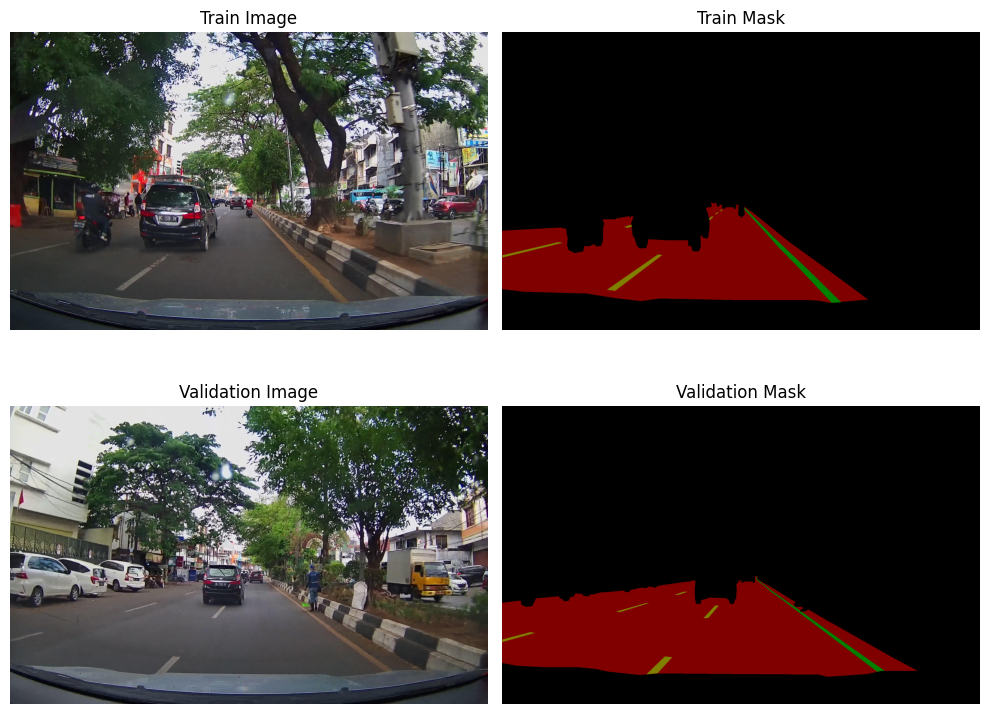

In [6]:
train_image_dir = 'train/images'
train_mask_dir = 'train/masks'
valid_image_dir = 'valid/images'
valid_mask_dir = 'valid/masks'

train_filename = '0060_Image1'
valid_filename = '0060_Image12'

train_img = Image.open(os.path.join(train_image_dir, train_filename + '.jpg'))
train_mask = Image.open(os.path.join(train_mask_dir, train_filename + '.png'))

valid_img = Image.open(os.path.join(valid_image_dir, valid_filename + '.jpg'))
valid_mask = Image.open(os.path.join(valid_mask_dir, valid_filename + '.png'))

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(train_img)
plt.title('Train Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(train_mask)
plt.title('Train Mask')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(valid_img)
plt.title('Validation Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(valid_mask)
plt.title('Validation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


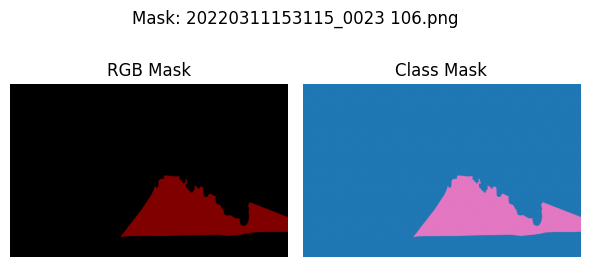

One-hot shape: (1600, 2560, 4)


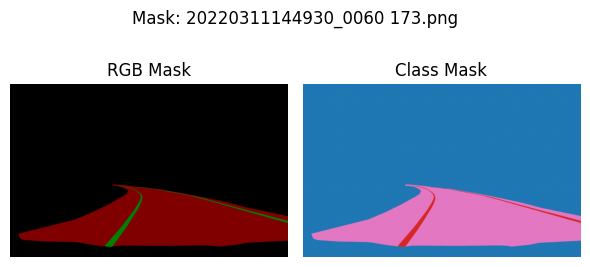

One-hot shape: (1600, 2560, 4)


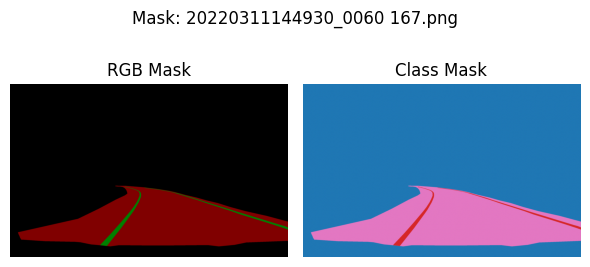

One-hot shape: (1600, 2560, 4)


In [7]:
COLOR_MAP = {
    (0, 0, 0): 0,
    (0, 128, 0): 1,
    (128, 0, 0): 2,
    (128, 128, 0): 3
}

NUM_CLASSES = len(COLOR_MAP)

def rgb_to_class(mask):
    mask = np.array(mask)
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for rgb, idx in COLOR_MAP.items():
        class_mask[np.all(mask == rgb, axis=-1)] = idx
    return class_mask

def one_hot_encode(mask, num_classes=NUM_CLASSES):
    return tf.one_hot(mask, num_classes)

mask_dir = "train/masks"

sample_filenames = random.sample(os.listdir(mask_dir), 3)

for fname in sample_filenames:
    path = os.path.join(mask_dir, fname)

    mask_rgb = Image.open(path).convert('RGB')

    mask_class = rgb_to_class(mask_rgb)

    mask_one_hot = one_hot_encode(mask_class)

    plt.figure(figsize=(6, 3))
    plt.suptitle(f'Mask: {fname}')

    plt.subplot(1, 2, 1)
    plt.title('RGB Mask')
    plt.imshow(mask_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Class Mask')
    plt.imshow(mask_class, cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f'One-hot shape: {mask_one_hot.shape}')  # [H, W, C]


In [8]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussianBlur(p=0.2),
    A.RandomCrop(width=256, height=256, p=1.0)
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
def apply_augmentation(image, mask):
    augmented = train_transform(image=np.array(image), mask=np.array(mask))
    return augmented['image'], augmented['mask']


In [23]:
def load_dataset(image_dir, mask_dir, img_size=(256, 256), augment=False):
    X, Y = [], []

    image_files = sorted([
        f for f in os.listdir(image_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    for filename in image_files:
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path).convert("RGB").resize(img_size)

        base_name = os.path.splitext(filename)[0] + ".png"
        mask_path = os.path.join(mask_dir, base_name)
        mask = Image.open(mask_path).convert("RGB").resize(img_size)

        img_np = np.array(img)
        mask_np = np.array(mask)

        if augment:
            augmented = train_transform(image=img_np, mask=mask_np)
            img_np = augmented['image']
            mask_np = augmented['mask']

        # Normalize image
        img_np = img_np / 255.0

        # Encode mask
        mask_class = rgb_to_class(mask_np)
        mask_onehot = tf.one_hot(mask_class, depth=NUM_CLASSES)

        X.append(img_np)
        Y.append(mask_onehot)

    X = np.array(X, dtype=np.float32)
    Y = tf.stack(Y)
    return X, Y


In [11]:
X_train_aug, Y_train_aug = load_dataset('train/images', 'train/masks', augment=True)

X_valid, Y_valid = load_dataset('valid/images', 'valid/masks', augment=False)


In [12]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = K.clip(y_pred, 0, 1)

    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])
    dice = (2. * intersection + smooth) / (sum_ + smooth)

    return K.mean(dice)

In [13]:
def unet_model(input_shape=(256, 256, 3), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = models.Model(inputs, outputs)
    return model


In [14]:
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,940 (118.38 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy',MeanIoU(num_classes=4, name='iou'), dice_coefficient])

history = model.fit(x=X_train_aug, y=Y_train_aug, batch_size=16, epochs=50, validation_data=(X_valid, Y_valid), callbacks = callbacks)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 190s 6s/step - accuracy: 0.7305 - dice_coefficient: 0.1582 - iou: 0.3750 - loss: 1.2531 - val_accuracy: 0.8420 - val_dice_coefficient: 0.2399 - val_iou: 0.3750 - val_loss: 0.5561 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 857ms/step - accuracy: 0.8456 - dice_coefficient: 0.2422 - iou: 0.3750 - loss: 0.5363 - val_accuracy: 0.8419 - val_dice_coefficient: 0.2601 - val_iou: 0.3750 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 883ms/step - accuracy: 0.8450 - dice_coefficient: 0.2650 - iou: 0.3750 - loss: 0.3994 - val_accuracy: 0.8420 - val_dice_coefficient: 0.3066 - val_iou: 0.3750 - val_loss: 0.2868 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 875ms/step - accuracy: 0.8437 - dice_coefficient: 0.3159 - iou: 0.3854 - loss: 0.2763 - val_accuracy: 0.8420 - val_dice_coefficient: 0.3491 - val_iou: 0.4715 - val_loss: 0.2137 - learning_rate: 1.0000e-04
Epoch 5/50
19/

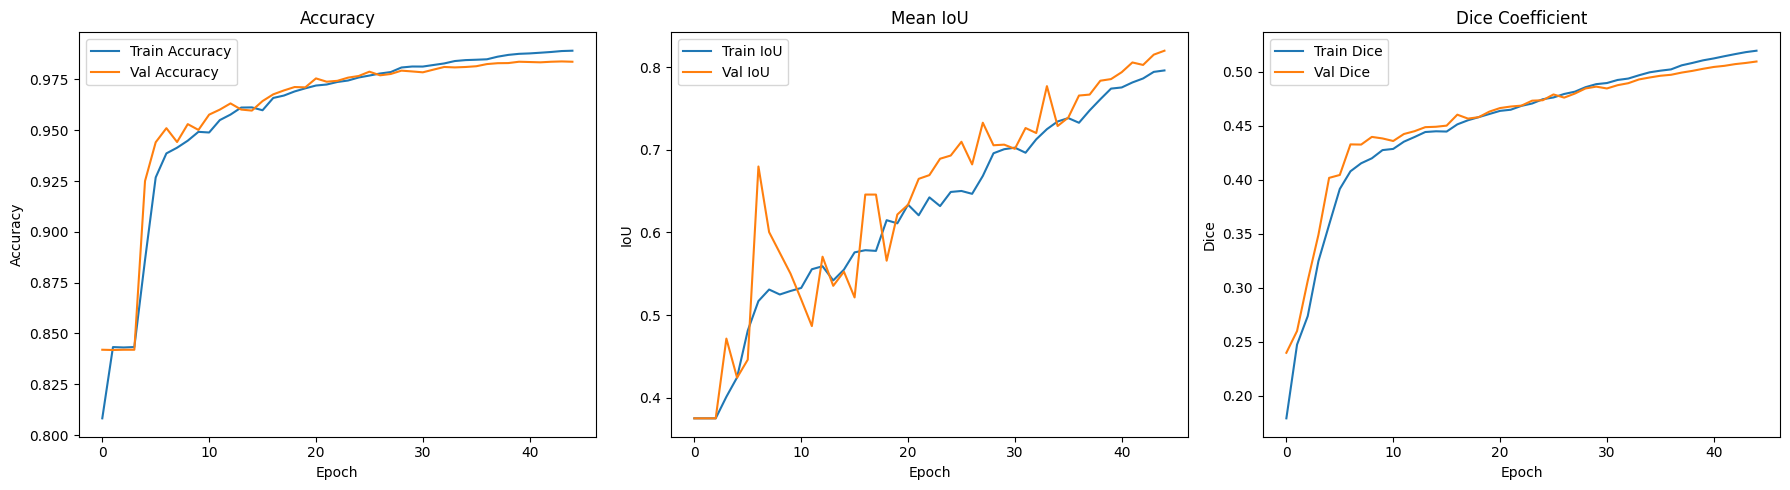

In [33]:
def plot_training_metrics(history):
    plt.figure(figsize=(18, 5))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU
    plt.subplot(1, 3, 2)
    plt.plot(history.history['iou'], label='Train IoU')
    plt.plot(history.history['val_iou'], label='Val IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


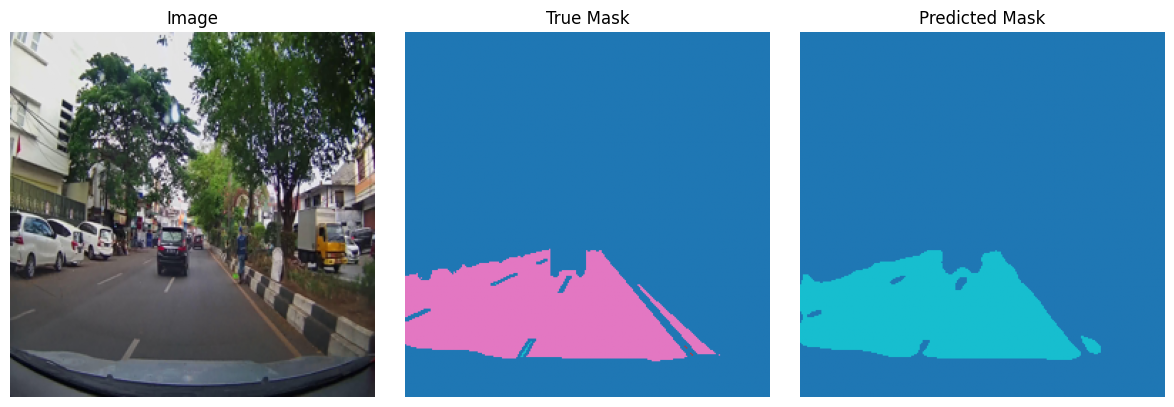

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


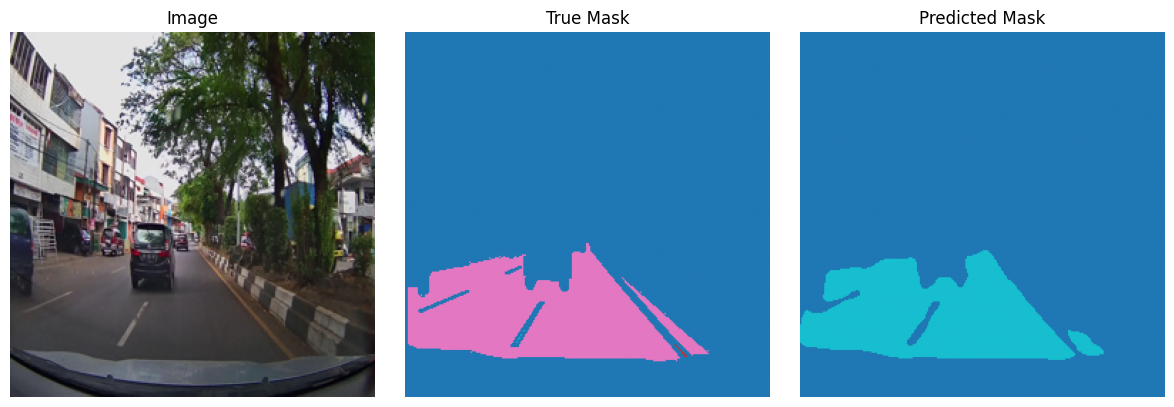

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


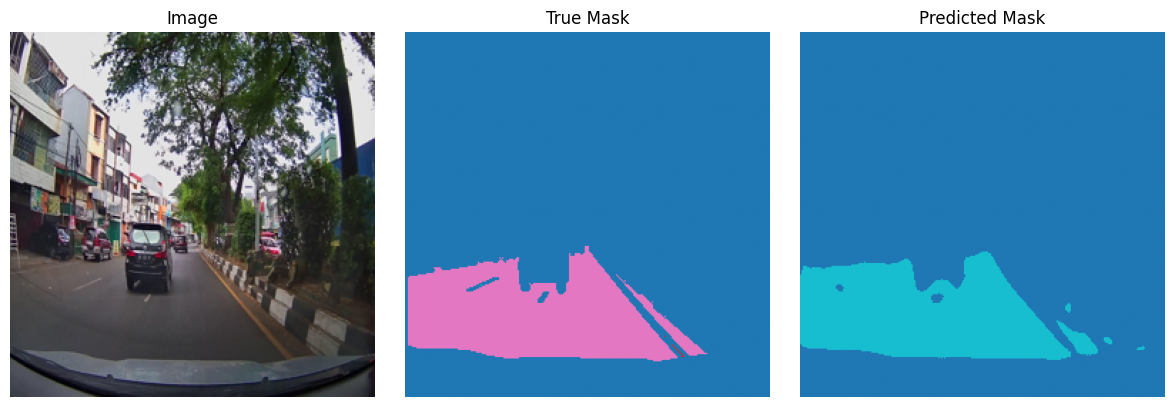

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


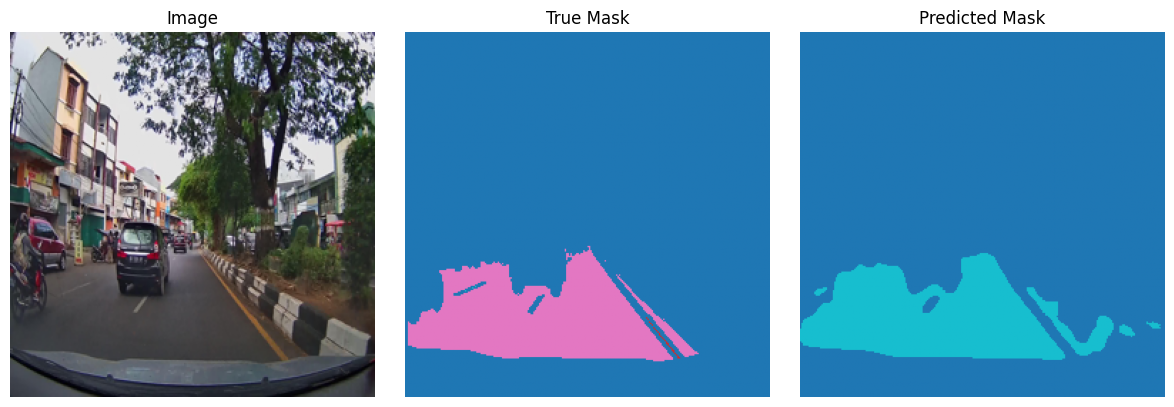

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


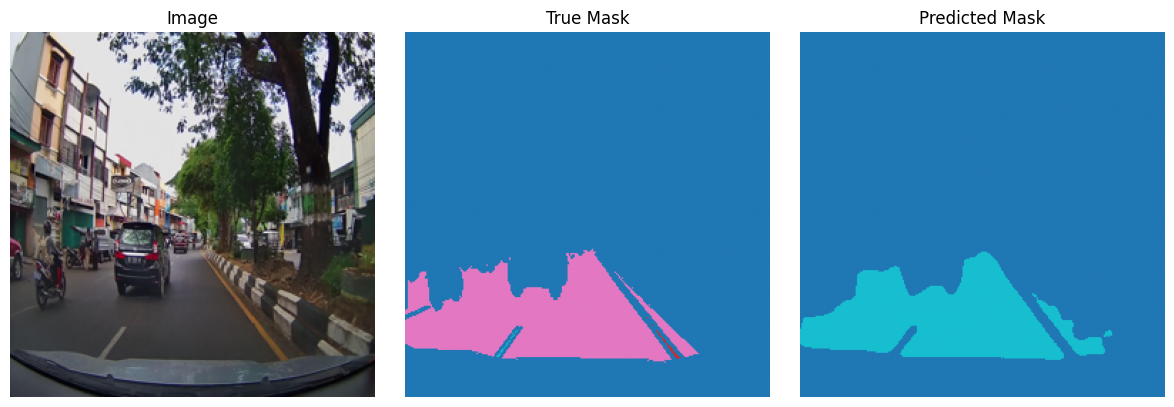

In [30]:
num_samples = 5

for i in range(num_samples):
    img = X_valid[i]
    true_mask = tf.argmax(Y_valid[i], axis=-1)
    pred_mask = tf.argmax(model.predict(X_valid[i:i+1])[0], axis=-1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask, cmap='tab10')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='tab10')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
